In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import geopandas as gpd

import extracting_points_from_polygons as pp

# Using Skicit-learn to split data into training and testing sets 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

import iceplant_detection_functionsCopy1 as ipf

In [2]:
def iceplant_counts(df):
    return df.filter(items=['iceplant']).groupby(['iceplant']).size().reset_index(name='count')


# def aoi_to_samples(root,aoi,year):
#     # root for all polygons collected on naip scenes
#     fp = os.path.join(root, 
#                       aoi+'_polygons', 
#                       aoi+'_polygons_'+str(year), 
#                       aoi+'_polygons_'+str(year)+'.shp')
#     polys = gpd.read_file(fp)
#     itemid = polys['naip_id'][0]
#     points = pp.naip_sample_no_warnings(polys,itemid)
#     return points

In [3]:
root = '/home/jovyan/msai4earth-esa/iceplant_detection'
aois = gpd.read_file(os.path.join(root,'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[0]  # Campus Lagoon aoi

In [4]:
aoi = 'campus_lagoon'
year = 2018 
fp = pp.path_to_polygons(aoi,year)
polys = gpd.read_file(fp)
#polys_raw

## Sampling 20% of pixels

In [5]:
sample1 = pp.naip_sample_proportion_no_warnings(polys, polys.naip_id[0], 0.2)

In [6]:
ipf.iceplant_proportions(sample1.iceplant)

no-iceplant:iceplant ratio     62.2 :1
          counts  percentage
iceplant                    
0         100065       98.42
1           1609        1.58



### Random forest

Text(0.5, 1.0, 'point samples by polygon id --- 0.2 samples')

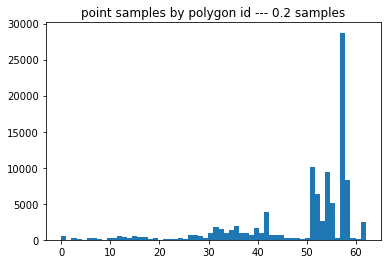

In [7]:
plt.hist(sample1.polygon_id,bins=60)
plt.title('point samples by polygon id --- 0.2 samples')

In [8]:
counts = np.unique(sample1.polygon_id.to_numpy(), return_counts=True)
counts = pd.DataFrame({'poly_id':counts[0], 'count':counts[1]}).sort_values(by=['count'], ascending=False)
counts.head(10)

,poly_id,count
54,57,28729
48,51,10066
51,54,9412
55,58,8334
49,52,6398
52,55,5071
39,42,3827
50,53,2667
59,62,2109
33,36,1852


In [9]:
counts.tail(5)

,poly_id,count
4,4,96
0,0,59
23,25,51
5,5,39
2,2,32


In [10]:
sample1.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample1 = sample1[['r','g','b','nir','iceplant']]
#sample1

In [11]:
# Labels & Features
y = np.array(sample1['iceplant'])
X = np.array(sample1.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [12]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y,predictions)


true negatives: 29934     false positives: 70
false negatives: 99     true positives: 400

sensitivity (TP/P): 80.16 %
specificity (TN/N): 99.77 %
G-mean:  0.89

precision (TP/(TP+FP)): 85.11 %

MCC:  0.8231617401894974

F1-measure:  0.82559
F0.5-measure (min false positives):  0.84069
F2-measure (min false negatives)  :  0.81103

accuracy: 99.45 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


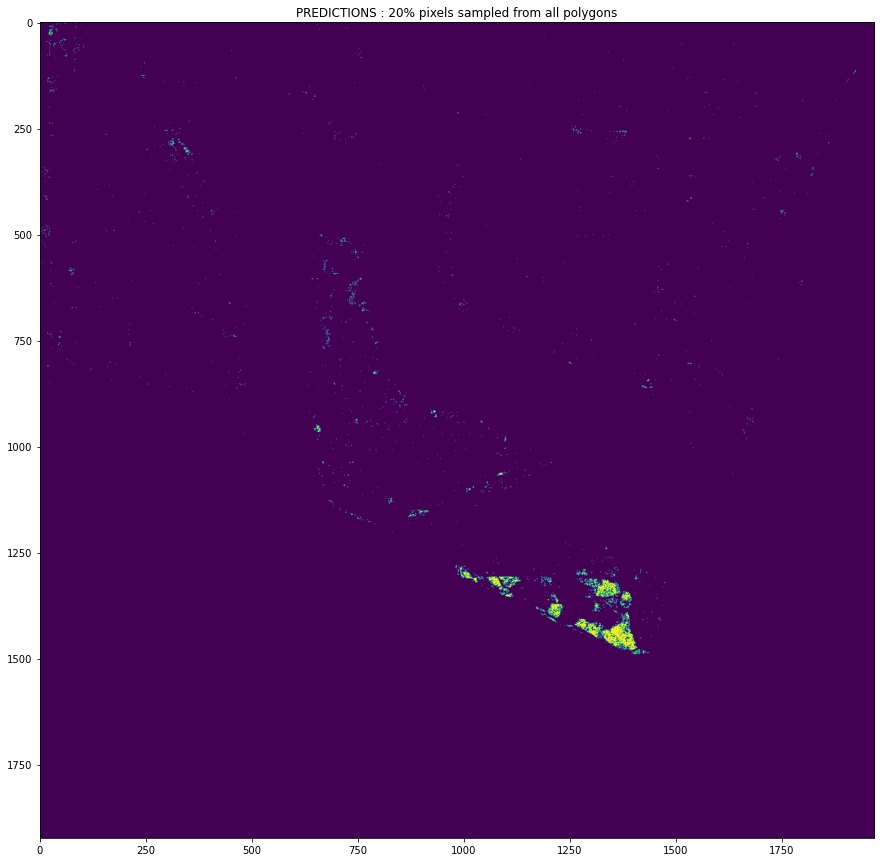

In [13]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 20% pixels sampled from all polygons")
ax.imshow(reconstructed)
plt.show()

## Sampling 0.8 iceplant, 0.2 non-iceplant

In [5]:
polys_iceplant = polys.loc[polys.iceplant==1]
polys_iceplant.reset_index(inplace=True, drop=True)

polys_noniceplant = polys.loc[polys.iceplant==0]
polys_noniceplant.reset_index(inplace=True, drop=True)

In [6]:
pts_iceplant = pp.naip_sample_proportion_no_warnings(polys_iceplant, polys.naip_id[0], 0.8)

In [5]:
pts_noniceplant = pp.naip_sample_proportion_no_warnings(polys_noniceplant, polys.naip_id[0], 0.2)

In [16]:
sample2 = pd.concat([pts_iceplant, pts_noniceplant])
ipf.iceplant_proportions(sample2.iceplant)

no-iceplant:iceplant ratio     15.5 :1
          counts  percentage
iceplant                    
0         100065       93.95
1           6449        6.05



In [17]:
sample2.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample2 = sample2[['r','g','b','nir','iceplant']]

In [18]:
# Labels & Features
y = np.array(sample2['iceplant'])
X = np.array(sample2.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [19]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y, predictions)


true negatives: 29889     false positives: 166
false negatives: 141     true positives: 1759

sensitivity (TP/P): 92.58 %
specificity (TN/N): 99.45 %
G-mean:  0.96

precision (TP/(TP+FP)): 91.38 %

MCC:  0.914651468940732

F1-measure:  0.91974
F0.5-measure (min false positives):  0.91615
F2-measure (min false negatives)  :  0.92336

accuracy: 99.04 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


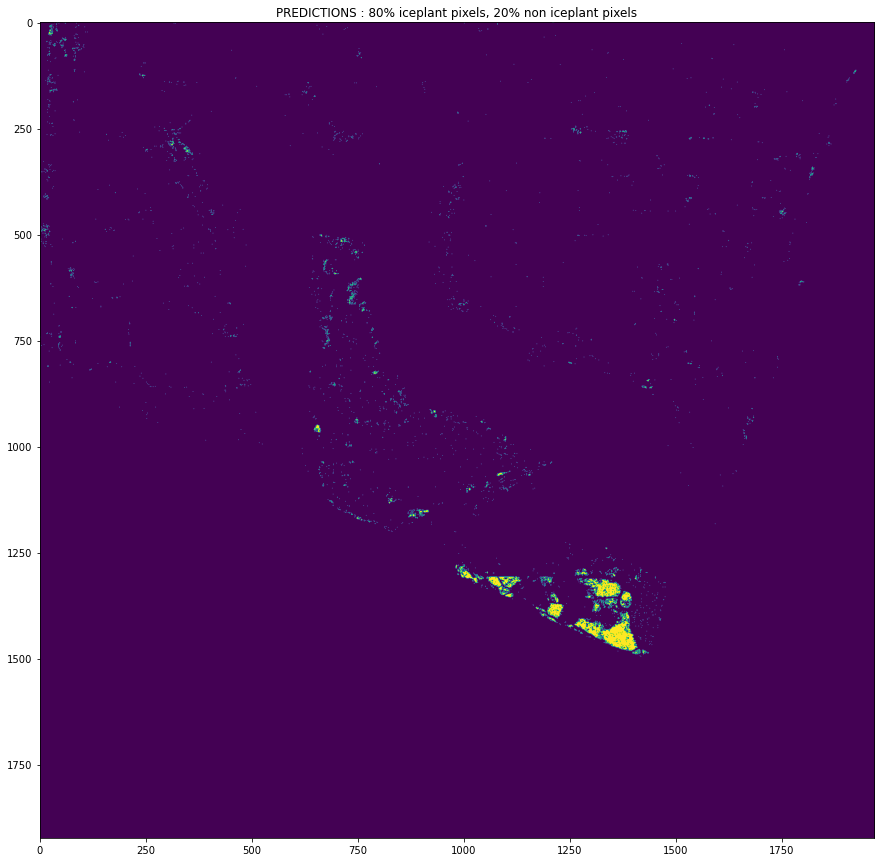

In [20]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 80% iceplant pixels, 20% non iceplant pixels")
ax.imshow(reconstructed)
plt.show()

## Custom sampling
Sampling 250 pts from each non-iceplant polygon and 80% of all pixels in the iceplant polygons

In [116]:
pts_non250 = pp.naip_sample_n_no_warnings(polys_noniceplant, polys.naip_id[0], 250)

In [117]:
sample3 = pd.concat([pts_iceplant, pts_non250])
ipf.iceplant_proportions(sample3.iceplant)

no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0          12750       66.41
1           6449       33.59



In [118]:
sample3.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample3 = sample3[['r','g','b','nir','iceplant']]

In [119]:
# Labels & Features
y = np.array(sample3['iceplant'])
X = np.array(sample3.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [120]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y,predictions)


true negatives: 3781     false positives: 59
false negatives: 48     true positives: 1872

sensitivity (TP/P): 97.5 %
specificity (TN/N): 98.46 %
G-mean:  0.98

precision (TP/(TP+FP)): 96.94 %

MCC:  0.9582717257976391

F1-measure:  0.97222
F0.5-measure (min false positives):  0.97055
F2-measure (min false negatives)  :  0.97388

accuracy: 98.14 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


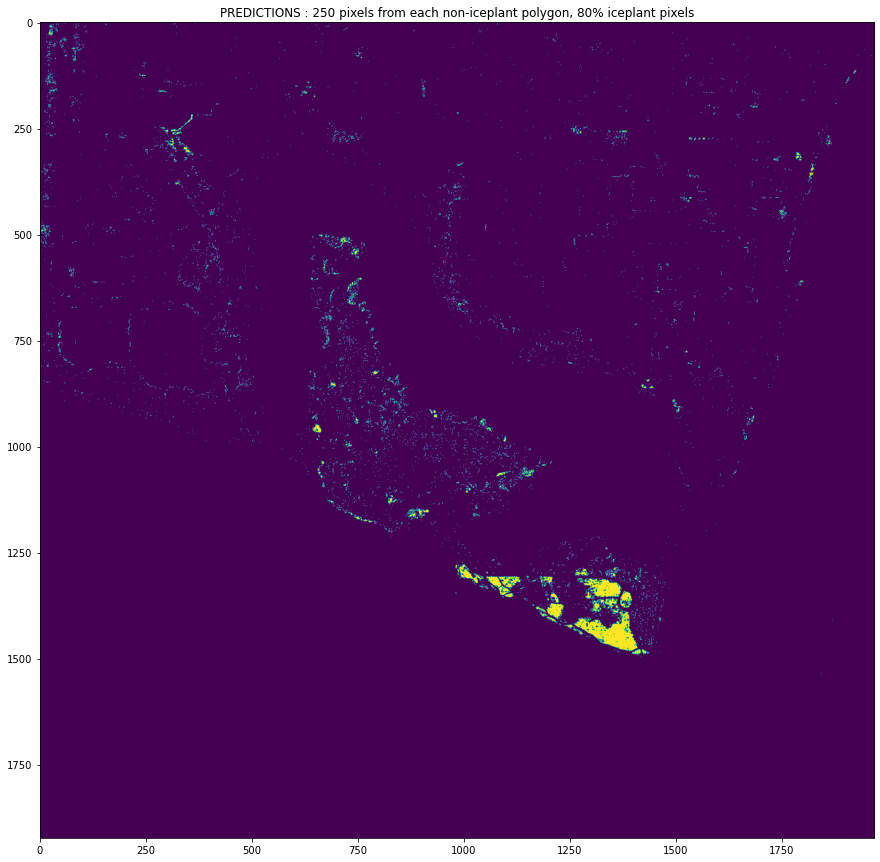

In [121]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 250 pixels from each non-iceplant polygon, 80% iceplant pixels")
ax.imshow(reconstructed)
plt.show()

In [ ]:
# df = pd.concat([pts_ice,pts_nonice])
# df.drop(['geometry','x','y','naip_id','polygon_id','month','day','year'], axis=1, inplace=True)
# df['ndvi'] = (df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
# df = df[['r','g','b','nir','ndvi','iceplant']]
# df

## Sliding proportions

In [7]:
ptsnon_sliding = pp.naip_sample_sliding_no_warnings(polys_noniceplant, polys.naip_id[0],0.8,1000)

0     143645
1      50332
2      47062
3      41672
4      31994
5      25358
6      19137
7      13335
8      10549
9       9261
10      8622
11      8120
12      7268
13      7118
14      4856
15      4843
16      4749
17      4485
18      4413
19      3642
20      3318
21      3257
22      3086
23      3086
24      3079
25      2552
26      2547
27      2363
28      2186
29      2056
30      1659
31      1640
32      1489
33      1450
34      1425
35      1325
36      1282
37      1236
38      1202
39      1175
40      1043
41      1036
42       991
43       954
44       869
45       833
46       729
47       691
48       608
49       544
50       256
Name: pixels, dtype: int64
[0.00838734 0.02390916 0.03943098 0.05495279 0.07047461 0.08599643
 0.10151824 0.11704006 0.13256188 0.14808369 0.16360551 0.17912733
 0.19464915 0.21017096 0.22569278 0.2412146  0.25673641 0.27225823
 0.28778005 0.30330186 0.31882368 0.3343455  0.34986731 0.36538913
 0.38091095 0.39643276 0.41195458 0.427476

In [15]:
ptsnon_sliding.polygon_id.value_counts()

58    2289
52    2254
55    2180
42    1942
54    1855
53    1560
35    1495
40    1454
33    1414
32    1410
62    1398
36    1371
34    1269
38    1221
30    1219
57    1204
51    1203
39    1172
37    1168
45    1127
44    1104
41    1095
43    1088
27    1079
26    1057
28    1049
15    1011
12    1010
16     968
13     942
61     802
17     786
19     763
59     754
48     752
14     730
46     727
47     721
11     720
50     719
56     667
10     656
24     654
29     644
60     600
21     588
22     526
18     509
23     458
49     418
25     200
Name: polygon_id, dtype: int64

Text(0.5, 1.0, 'point samples by polygon id --- 0.2 samples')

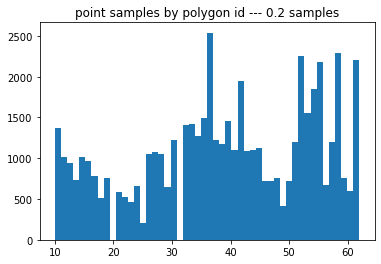

In [8]:
plt.hist(ptsnon_sliding.polygon_id, bins=50)
plt.title('point samples by polygon id --- 0.2 samples')

In [9]:
sample4 = pd.concat([pts_iceplant, ptsnon_sliding])
ipf.iceplant_proportions(sample4.iceplant)

no-iceplant:iceplant ratio     8.4 :1
          counts  percentage
iceplant                    
0          54002       89.33
1           6449       10.67



In [10]:
sample4.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample4 = sample4[['r','g','b','nir','iceplant']]

In [11]:
# Labels & Features
y = np.array(sample4['iceplant'])
X = np.array(sample4.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [12]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y,predictions)


true negatives: 16059     false positives: 119
false negatives: 99     true positives: 1859

sensitivity (TP/P): 94.94 %
specificity (TN/N): 99.26 %
G-mean:  0.97

precision (TP/(TP+FP)): 93.98 %

MCC:  0.937887539346865

F1-measure:  0.94461
F0.5-measure (min false positives):  0.94174
F2-measure (min false negatives)  :  0.9475

accuracy: 98.8 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


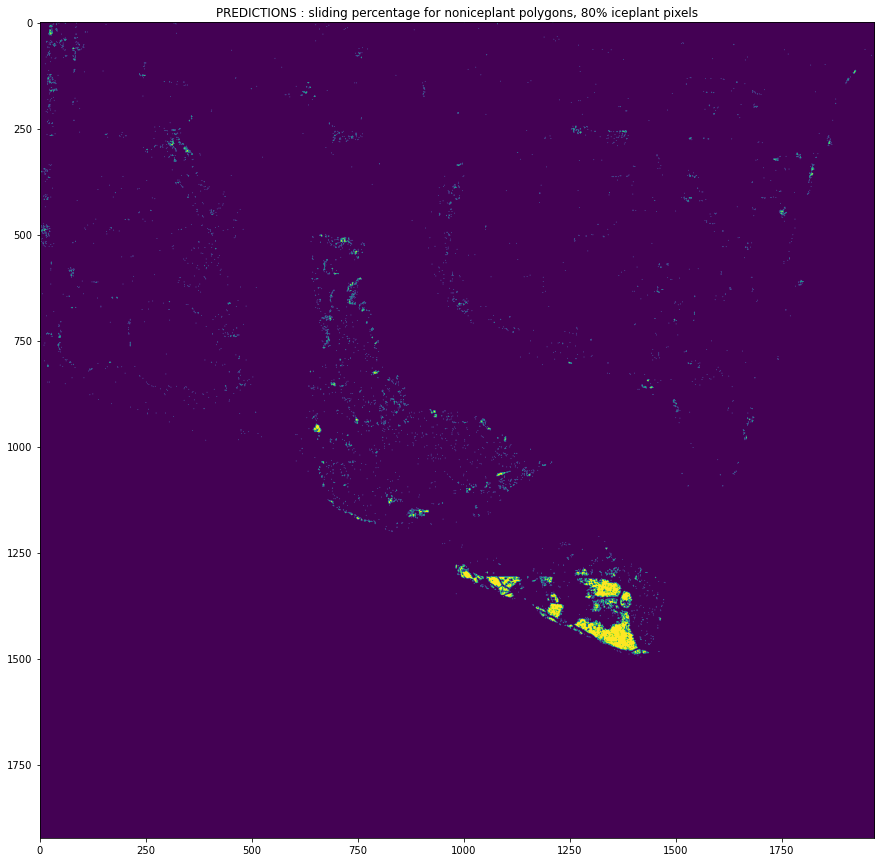

In [13]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : sliding percentage for noniceplant polygons, 80% iceplant pixels")
ax.imshow(reconstructed)
plt.show()

# Proportion of small ones, fixed number in big oines

In [7]:
ptsnon_sliding = pp.naip_sample_sliding_no_warnings(polys_noniceplant, polys.naip_id[0], 0.8, 1200)

0     143645
1      50332
2      47062
3      41672
4      31994
5      25358
6      19137
7      13335
8      10549
9       9261
10      8622
11      8120
12      7268
13      7118
14      4856
15      4843
16      4749
17      4485
18      4413
19      3642
20      3318
21      3257
22      3086
23      3086
24      3079
25      2552
26      2547
27      2363
28      2186
29      2056
30      1659
31      1640
32      1489
33      1450
34      1425
35      1325
36      1282
37      1236
38      1202
39      1175
40      1043
41      1036
42       991
43       954
44       869
45       833
46       729
47       691
48       608
49       544
50       256
Name: pixels, dtype: int64
[114916.   40265.6  37649.6  33337.6  25595.2  20286.4  15309.6  10668.
   8439.2   7408.8   6897.6   6496.    5814.4   5694.4   3884.8   3874.4
   3799.2   3588.    3530.4   2913.6   2654.4   2605.6   2468.8   2468.8
   2463.2   2041.6   2037.6   1890.4   1748.8   1644.8   1327.2   1312.
   1191.2   1160.   

In [10]:
sample5 = pd.concat([pts_iceplant, ptsnon_sliding])
ipf.iceplant_proportions(sample5.iceplant)

no-iceplant:iceplant ratio     8.3 :1
          counts  percentage
iceplant                    
0          53703       89.28
1           6449       10.72



In [11]:
sample5.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample5 = sample5[['r','g','b','nir','iceplant']]

In [12]:
# Labels & Features
y = np.array(sample5['iceplant'])
X = np.array(sample5.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [13]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y,predictions)


true negatives: 15972     false positives: 109
false negatives: 106     true positives: 1859

sensitivity (TP/P): 94.61 %
specificity (TN/N): 99.32 %
G-mean:  0.97

precision (TP/(TP+FP)): 94.46 %

MCC:  0.9386491674093503

F1-measure:  0.94533
F0.5-measure (min false positives):  0.9449
F2-measure (min false negatives)  :  0.94577

accuracy: 98.81 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


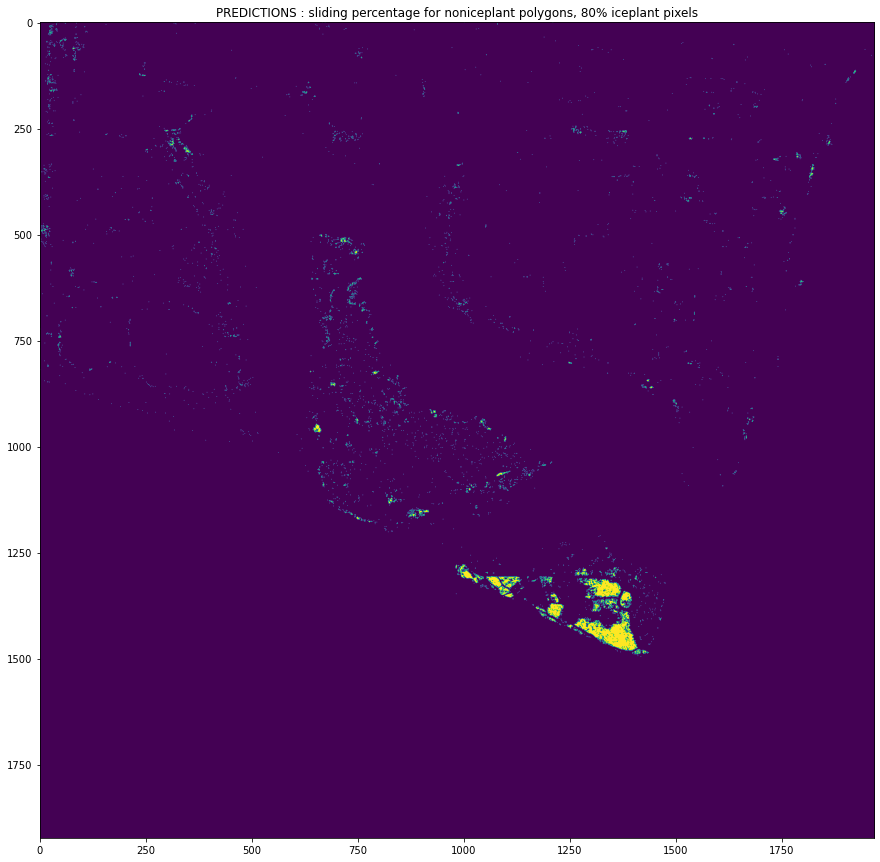

In [14]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : sliding percentage for noniceplant polygons, 80% iceplant pixels")
ax.imshow(reconstructed)
plt.show()